***Modelling to identify if a book will be loved by Art Garfunkel.***

# Introduction 
Recently an interesting dataset was uploaded to Kaggle. The Art Garfunkel's Library dataset consists of information on over 1300 books that Garfunkel has read since 1968. As an individual who also enjoys reading, I was intrigued about Garfunkel's reading habits and was particularly curious about whether Garfunkel's enjoyment of a book can be predicted. 

# Overview 
To understand Garfunkel's reading habits as well as creating a model that could predict if a specific book read by Garfunkel will be in his favourites the following steps would be required: 
* Understanding the data 
* Creating a logistic and random forest 


# Understanding the data  



In [1]:
# libraries for data handling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# libraries specific for Kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


/kaggle/input/art-garfunkels-library/Art Garfunkel Library.csv


In [2]:
df = pd.read_csv("/kaggle/input/art-garfunkels-library/Art Garfunkel Library.csv")

The dataset has 6 columns and include information on date read, author, books, year published, pages and favourite.  

On face value, it appears that there are no null values but columns, date read and year published, will need to be formatted. However it may be best to examine the dataset in more depth for any further issues and secure a more in-depth understanding of the data. 

In [3]:
df.head()

,Date Read,Author,Books,Year Published,Pages,Favorite
0,Jun-68,Jean-Jacques Rousseau,The Confessions,1781,606,1
1,Jun-68,Erich Fromm,The Art of Loving,1956,146,1
2,Jun-68,Mark Twain,The Adventures of Huckleberry Finn,1884,288,0
3,Jul-68,James Thurber,My Life and Hard Times,1933,115,0
4,Jul-68,William Shakespeare,Romeo and Juliet,1596,146,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321 entries, 0 to 1320
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date Read       1321 non-null   object
 1   Author          1321 non-null   object
 2   Books           1321 non-null   object
 3   Year Published  1321 non-null   object
 4   Pages           1321 non-null   int64 
 5   Favorite        1321 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 62.0+ KB


# Books

There are over 1300 unique titles and includes some rereads. 

In [5]:
print("No of unique titles - ", df["Books"].nunique())

No of unique titles -  1305


Reread books applies to titles such as "The Confessions". There are also books with similar titles as exemplified by the book "Autobiography", one by W. B Yeats and the other by Benvenuto Cellini.

In [6]:
df["Books"].value_counts()

The Confessions                               3
Autobiography                                 3
The Last Interview                            2
Othello                                       2
The Europeans                                 2
                                             ..
The Solace of Open Spaces                     1
Notes from the Underground                    1
Tom Sawyer Abroad and Tom Sawyer Detective    1
Singers and the Song                          1
Saving Freedom                                1
Name: Books, Length: 1305, dtype: int64

In [7]:
df[df["Books"].duplicated()].sort_values(by = "Books").head()

,Date Read,Author,Books,Year Published,Pages,Favorite
167,Dec-79,W.B. Yeats,Autobiography,1922,387,0
192,Jul-81,Benvenuto Cellini,Autobiography,1562,397,0
262,Sep-83,Aaron Copland,Copland on Music,1959,280,0
1192,Oct-13,Witold Gombrowicz,Cosmos,1967,208,0
836,Dec-00,Sir Harold Nicolson,Diplomacy,1939,151,0


Furthermore, rereads appear to have been done with different books. For example, Othello has two differing page numbers. This is a common feature of books as some may have introductions and notes. Font size will also differ between editions impacting the page count. 


In [8]:
# different books?
df[df["Books"]=="Othello"]

,Date Read,Author,Books,Year Published,Pages,Favorite
49,Jan-71,William Shakespeare,Othello,1602,128,0
317,Oct-84,William Shakespeare,Othello,1604,154,0


This extract of Othello raises some concerns. The year published appears to be different. This could refer to one of two things. 
1. There are error/typo in the year published.
2. Year published refer to the year in which Garfunkel's edition of the book was first published. Different editions of books can and will have differing first publication dates. 

Given that the dates listed are in 1602 and 1604, it is somewhat unlikely that Garfunkel has read these specific editions of the books, even if he possessed the editions. Therefore, these are likely to be errors. 

However, rectifying these errors will be extremely complex. Sites such as Amazon typically list the publication date of the specific edition. Likewise, whilst Wikipedia and other sites will have the initial publication date, there is no guaranteed that all the books read will have a corresponding page.  

Consequently, this project will have to proceed with the information as is. 

Finally for rereads, it appears that books were not marked as favourites in neither the initial or second read. Therefore there is no alterations required for the favourites with regards to rereads. 


In [9]:
# no fav books in duplicates and therefore favorits dont change between rereads 
df[df["Books"].duplicated()]["Favorite"].sum()

0

# Favorite
Speaking of the favourites variable, it is a binary column allocating 1 for a favourite and 0 for a non-favourite. The majority of the books are not marked as a favourite book.

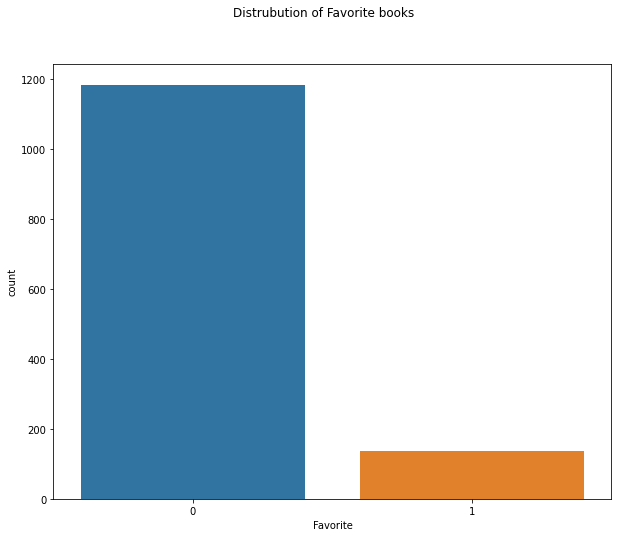

In [10]:
plt.figure(figsize = (10,8))
sns.countplot(x = "Favorite", data = df)
plt.suptitle("Distrubution of Favorite books")
plt.show()

Only just over 10% of the books are singled out. 

Although, this is reasonable, this will cause issues with the models.  A simple model reporting that all books are not a favourite will provide an accuracy rating of just under 90%. 

In [11]:
print(round(((df[df["Favorite"] ==1].shape[0]/df.shape[0])*100),3), "% of the books were favorites")

10.295 % of the books were favorites


# Author
Garfunkel appears to have read more books by specific authors than others. Also for some authors he is more likely to find a favourite book than others. Marcel Proust and L.N. Tolstoy appear to be particularly favoured. 


In [12]:
df["Author"].value_counts()

William Shakespeare      15
Charles Dickens          10
Jean-Jacques Rousseau     9
Marcel Proust             8
Various                   7
                         ..
J.P. Kenyon               1
Michel Foucault           1
Ian Frazier               1
Anne Rice                 1
Joe Scarborough           1
Name: Author, Length: 966, dtype: int64

In [13]:
# favorite authors exist
df.groupby("Author")["Favorite"].sum().sort_values(ascending=False)

Author
Marcel Proust                    5
L.N. Tolstoy                     4
Jean Rhys                        3
Vladimir Nabokov                 2
Mark Twain                       2
                                ..
Giambattista Vico                0
Giorgio Vasari                   0
Giovanni Boccaccio               0
Giovanni Pico della Mirandola    0
editor, Eric L. McKitrick        0
Name: Favorite, Length: 966, dtype: int64

There are some books which may have multiple authors and this dataset is no exception. There can be as high as 25 authors in a single book. There are different possibilities in handling these data. The authors could be divided into individuals and then modelled accordingly or handled as a single unit and assessed accordingly.  For the purpose of this project, the variable will be considered in its current form as it is likely that the combination of the authors has an impact on the book and the enjoyability than a sole author. 


In [14]:
# multiple author books
#df["Author"].unique()

df["Author"].str.split(',', expand=True).dropna(thresh=2)

,0,1,2,3
17,Jule Eisenbud,M.D.,None,None
107,Kurt Vonnegut,Jr.,None,None
211,David C. Gompert,Michael Mandelbaum,Richard L. Garwin,John H. Barton
213,Willard Gaylin,Ira Glasser,Steven Marcus,David Rochman
275,Sappho,Pindar,Solon,and 23 others
288,William Strunk,Jr. and E.B. White,None,None
434,Roger Fisher,William Ury,None,None
453,Michael J. Malbin,ed.,None,None
506,Noam Chomsky,Edward S. Herman,None,None
522,Paul Magriel,John T. Spike,None,None


# Pages
The pages has a right skew as the majority of the books are less than 500 pages. Mathematically the books with over 750 pages are considered outliers. However, as books can have more than 750 pages, such longer books should not be dropped from the dataset.  That being said, Garfunkel is more likely to enjoy books around 250 pages than longer looks which he rarely reads. 

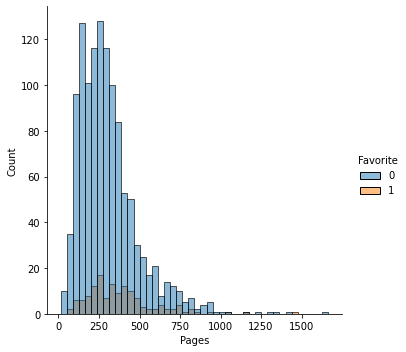

In [15]:
sns.displot(x= "Pages", data = df, hue = "Favorite")

<AxesSubplot:xlabel='Pages'>

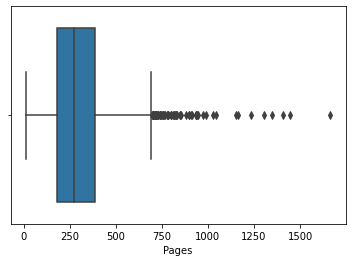

In [16]:
sns.boxplot(x= "Pages", data = df, )

# Year Published 

Leaving aside possible errors in the accuracy of the data previously mentioned, there are also other issues which need to be resolved before the data could be modelled. 

Firstly, there are two values that contain two incorrect values that should be replaced. In addition some publication dates are BC. There may be various methods to resolve the issue, the method used here is to convert all BC publications to a negative number. This should enable the data to be formatted correctly. 


In [17]:
# rectify the two typos
df["Year Published"].replace(["1,981","398ad"], ["1981","398"],  inplace = True)

# convert BC dates to negative numbers
df["Year_Published_numerical"] = df["Year Published"].apply(lambda x: "-"+x[:-2] if x[-2:]=="bc" else x)

# revise the data to numerical values
df["Year_Published_numerical"] = df["Year_Published_numerical"].astype(int)

Examining the distribution it is clear that the majority of the books Garfunkel has read are centred around the 1800-1900s.

The favourite books relative to publication year also seems to follow the overall pattern established by this variable.

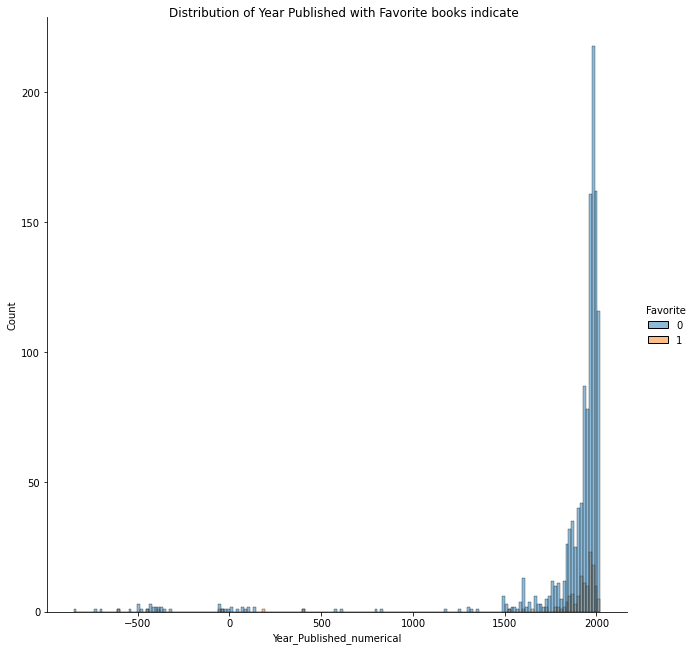

In [18]:
sns.displot(x = "Year_Published_numerical", data = df, hue = "Favorite", height = 9)
plt.suptitle("Distribution of Year Published with Favorite books indicate", y = 1)
plt.show()

In [19]:
df["Year_Published_numerical"].describe()

count    1321.000000
mean     1848.776684
std       422.118396
min      -850.000000
25%      1900.000000
50%      1963.000000
75%      1987.000000
max      2021.000000
Name: Year_Published_numerical, dtype: float64

# Date Read
Date Read has the most issues. Looking at a bird's eye view indicates that in general the variable consists of month and year. However, there are several entries where only a year has been included. 


In [20]:
df["Date Read"].unique()

array(['Jun-68', 'Jul-68', 'Aug-68', 'Sep-68', 'Oct-68', 'Nov-68',
       'Dec-68', 'Jan-69', 'Feb-69', 'May-69', 'Jun-69', 'Jul-69',
       'Aug-69', 'Sep-69', 'Jan-70', 'Feb-70', 'Mar-70', 'Apr-70',
       'May-70', 'Jul-70', 'Aug-70', 'Sep-70', 'Oct-70', 'Nov-70',
       'Dec-70', 'Jan-71', 'Feb-71', 'Mar-71', 'Apr-71', 'Jun-71',
       'Jul-71', 'Aug-71', 'Sep-71', 'Oct-71', 'Nov-71', 'Dec-71',
       'Jan-72', 'Feb-72', 'Mar-72', 'Apr-72', 'Aug-72', 'Sep-72',
       'Oct-72', 'Feb-73', 'Apr-73', 'Jun-73', 'Jul-73', 'Aug-73',
       'Sep-73', 'Oct-73', 'Nov-73', 'Dec-73', 'Jan-74', 'Feb-74',
       'Mar-74', 'Apr-74', 'May-74', 'Jul-74', 'Aug-74', 'Oct-74',
       'Nov-74', 'Dec-74', 'Feb-75', 'Jun-75', 'Sep-75', 'Jan-76',
       'Feb-76', 'Mar-76', 'Apr-76', 'Jul-76', 'Dec-76', 'Jan-77',
       'Feb-77', 'May-77', 'Jun-77', 'Jul-77', 'Sep-77', 'Aug-77',
       'Nov-77', 'Dec-77', 'Mar-78', 'Apr-78', 'May-78', 'Jun-78',
       'Aug-78', 'Sep-78', 'Nov-78', 'Feb-79', 'Mar-79', 'May-

Firstly, it may be best to split the variables into its key components year and month, using a dummy for those where a month variable is missing.


In [21]:
# fix syntax setting xxx for months unknown
df["Date Read"] = df["Date Read"].apply(lambda x: x if len(x)>5 else "xxx-"+x[-2:])

In [22]:
df[["Month", "Year"]] = df["Date Read"].str.split('-', expand=True)

Year can now be processed easily.

In [23]:
df["Year"] = df["Year"].astype(int)

In [24]:
df["Year"] = df["Year"].apply(lambda x: x+2000 if x <68 else x+1900)
 

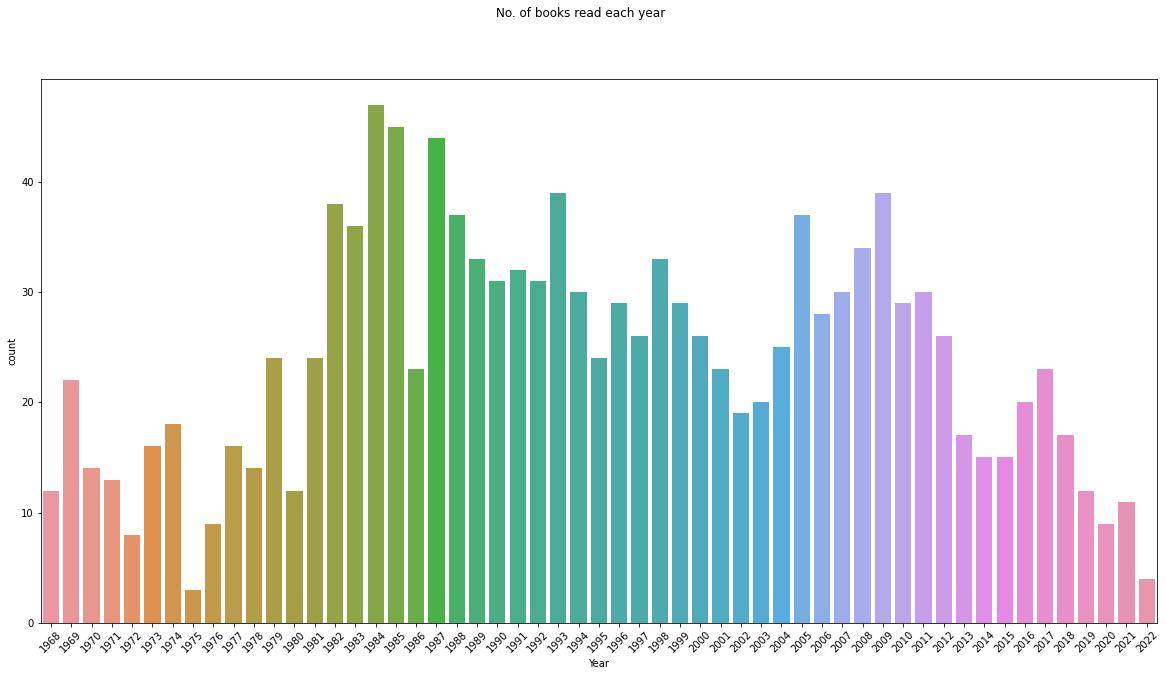

In [25]:
plt.figure(figsize = (20,10))
sns.countplot( x = "Year", data = df)
plt.suptitle("No. of books read each year")
plt.xticks(rotation = 45)
plt.show()

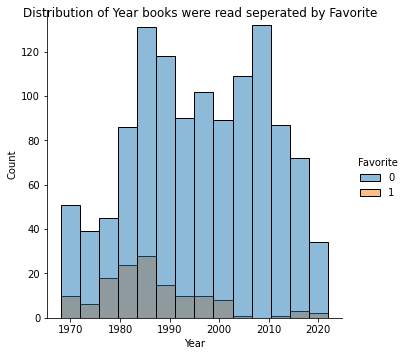

In [26]:
sns.displot(x = "Year", data = df, hue = "Favorite")
plt.suptitle("Distribution of Year books were read seperated by Favorite")
plt.show()

There were more books read before 2005 were likely to be listed as a favourite book. 

In contrast, for month, there are still some issues to resolve. There are null values in this variable. One option to resolve this issue would be to list such books as being read in Dec, the last possible month to read a book. However this will distort the accuracy of Dec. With 125 entries without a month which constitutes 9% of the data, this is not ideal. 

Subsequently, it may be best to attempt to make a model that excludes the month column complete and an alternative model which excludes the missing month data. 


In [27]:
df[df["Month"]=="xxx"].shape[0]

125

In [28]:
print(round((df[df["Month"]=="xxx"].shape[0]/df.shape[0])*100,2),"of books have no recorded reading month")

9.46 of books have no recorded reading month


In [29]:
print(round((sum(df[df["Month"]=="xxx"]["Favorite"])/sum(df["Favorite"]))*100,2),"of favourite books have no recorded reading month")

2.94 of favourite books have no recorded reading month


In [30]:
# Years for which reading month is missing
df[df["Month"]=="xxx"]["Year"].unique()

array([2005, 2006, 2007, 2008, 2018, 2019, 2020, 2021])

# Modelling Favourites
Before models can be created, author variable will need to be encoded.

In [31]:
from sklearn.preprocessing import LabelEncoder

In [32]:
le = LabelEncoder()
df["Author_code"] = le.fit_transform(df["Author"])

## Model Excluding reading month
Following this, the first model which could be made is a logistic regression as the favourite variable is binary. 

In [33]:
x = df[["Author_code", "Year_Published_numerical", "Pages", "Year"]]
y = df["Favorite"]

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix


In [35]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state= 360 )

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression()

In [38]:
predictions = logmodel.predict(X_test)

In [39]:
from sklearn.metrics import classification_report

In [40]:
print("Logistic Model - reading month excluded")
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))
# nope.. 

Logistic Model - reading month excluded
[[357   1]
 [ 39   0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       358
           1       0.00      0.00      0.00        39

    accuracy                           0.90       397
   macro avg       0.45      0.50      0.47       397
weighted avg       0.81      0.90      0.85       397



In the first instance, variables all but the book name which is too unique and the months, which still contain null values will be used in the model.

Sadly, the results of this model, appears to be no better than the initial model of simply allocating all books as being a non-favourite. 

Swapping the logistic model for a random forest, improves some measurements but performs no better than the logistic regression model. 


In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
RandomForest = RandomForestClassifier()
RandomForest.fit(X_train, y_train)

RandomForestClassifier()

In [43]:
RandomForest_pred = RandomForest.predict(X_test)

In [44]:
print("Random Forest Model - reading month excluded")

print(confusion_matrix(y_test,RandomForest_pred))
print(classification_report(y_test, RandomForest_pred))

Random Forest Model - reading month excluded
[[351   7]
 [ 38   1]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       358
           1       0.12      0.03      0.04        39

    accuracy                           0.89       397
   macro avg       0.51      0.50      0.49       397
weighted avg       0.83      0.89      0.85       397



# Model with reading Month
In order for the month variable to be used the entries pertaining to the null values will need to be dropped. 

In [45]:
df.drop(df[df["Month"]=="xxx"].index, axis = 0, inplace = True)

In [46]:
df["Month_no"] = pd.to_datetime(df["Month"], format = "%b").dt.month

In [47]:
x = df[["Author_code","Month_no", "Year_Published_numerical", "Pages", "Year"]]
y = df["Favorite"]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state= 360 )

In [49]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression()

In [50]:
predictions = logmodel.predict(X_test)

Doing so and running the two models, shows a decrease in the accuracy of the models. This may be due to the changes in the composition of the data as the missing months also included some favourite books, therefore making exacerbating the skew in the dataset favouring non-favourite books.

In [51]:
print("Logistic Model - reading month included")

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))

Logistic Model - reading month included
[[314   1]
 [ 44   0]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       315
           1       0.00      0.00      0.00        44

    accuracy                           0.87       359
   macro avg       0.44      0.50      0.47       359
weighted avg       0.77      0.87      0.82       359



In [52]:
RandomForest = RandomForestClassifier()
RandomForest.fit(X_train, y_train)

RandomForestClassifier()

In [53]:
RandomForest_pred = RandomForest.predict(X_test)

In [54]:
print("Random Forest Model - reading month included")

print(confusion_matrix(y_test,RandomForest_pred))
print(classification_report(y_test, RandomForest_pred))

Random Forest Model - reading month included
[[311   4]
 [ 43   1]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       315
           1       0.20      0.02      0.04        44

    accuracy                           0.87       359
   macro avg       0.54      0.51      0.49       359
weighted avg       0.80      0.87      0.82       359



# Conclusion 
It was fascinating to understanding the reading habits of Garfunkel and how widely read he is. I hope one day, I would have read as many books as Garfunkel. 

Unfortunately, the modelling whether a book will be regarded a book as a favourite did not lead to the results sought. All the models considered did not perform better than the base model of classifying all books as a non-favourite. 

It may be that using more complex models such as deep learning may yield better results. Also books have more key data than those included in this dataset. For instance Garfunkel may have a preference towards a specific genre. 

Leaving aside the success of the models, this project does highlight the importance of understanding the possible limitations of models. 

> *“So many books, so little time.”― [Frank Zappa](https://www.goodreads.com/quotes/tag?utf8=%E2%9C%93&id=books)*
